In [1]:
import os
import glob
from functools import reduce

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
results_dir = "../../../../../../results/"
base_dir = "timeseries/time-scales/"
arrival_rate = "2_X_max"
run_type = "single-backend"
fluctuation_timeperiod = "500ms-fluctuation"
run_time = "5mins-run"
feedback_intervals = ["5ms-feedback", "25ms-feedback", "205ms-feedback", "505ms-feedback", 
                      "1.005s-feedback", "5.005s-feedback"]
algos = ["wlc", 
         "feedback-wlc"]
runs = ["run"]

## Response rate

In [4]:
rr_percentiles = ['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                  'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                  'Response rate 99%', 'Response rate 100%'] 

In [5]:
rr_plot_data_dict = {}

for i in glob.glob(results_dir + base_dir + arrival_rate + "/" + run_type + "/" +  fluctuation_timeperiod + "/" + 
                   run_time + "/*/*/*/" + "response_rate.csv"):
    for feedback_interval in feedback_intervals:
        if ("/"+feedback_interval+"/") in i:
            for algo in algos:
                if ("/"+algo+"/") in i:
                    for run in runs:
                        if run in i:
                            rr_plot_data_dict[feedback_interval+":"+algo] = pd.read_csv(i, header=0, na_filter=False)

In [6]:
rr_plot_data = pd.DataFrame()
rr_plot_data['percentiles'] = rr_percentiles

rr_plot_percentile_dict = {}
for i in rr_percentiles:
    for k in rr_plot_data_dict:
        if k in rr_plot_percentile_dict:
            rr_plot_percentile_dict[k].append(rr_plot_data_dict[k][i][0])
        else:
            rr_plot_percentile_dict[k] = []
            rr_plot_percentile_dict[k].append(rr_plot_data_dict[k][i][0])
            
for k in rr_plot_data_dict:
    rr_plot_data[k] = rr_plot_percentile_dict[k]

In [7]:
# rr_plot_data.plot('percentiles', kind='bar')

## Response time

In [8]:
rt_percentiles = ['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                  'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                  'Response time 99%', 'Response time 100%']

In [20]:
rt_plot_data_dict = {}

for i in glob.glob(results_dir + base_dir + arrival_rate + "/" + run_type + "/" +  fluctuation_timeperiod + "/" + 
                   run_time + "/*/*/*/" + "response_time.csv"):
    for feedback_interval in feedback_intervals:
        if ("/"+feedback_interval+"/") in i:
            for algo in algos:
                if ("/"+algo+"/") in i:
                    for run in runs:
                        if run in i:
                            rt_plot_data_dict[feedback_interval+":"+algo] = pd.read_csv(i, header=0, na_filter=False)

In [23]:
rt_plot_data = pd.DataFrame()
rt_plot_data['percentiles'] = rt_percentiles

rt_plot_percentile_dict = {}
for i in rt_percentiles:
    for k in rt_plot_data_dict:
        if k in rt_plot_percentile_dict:
            rt_plot_percentile_dict[k].append(rt_plot_data_dict[k][i][0])
        else:
            rt_plot_percentile_dict[k] = []
            rt_plot_percentile_dict[k].append(rt_plot_data_dict[k][i][0])
            
for k in rt_plot_data_dict:
    rt_plot_data[k] = rt_plot_percentile_dict[k]

### Percentiles ...

500ms fluctuation, 0.5 alpha, 0.005 state feedback, 0.001 stat collection.

In [24]:
err_dict = {}
for feedback_interval in feedback_intervals:
    for algo in algos:
        err_dict[feedback_interval+":"+algo] = pd.DataFrame()

index = ['Avg.', '50%', '66%', '75%', '80%', '90%', '95%', '98%', '99%', '100%']        
means = pd.DataFrame()
means['percentiles'] = index
errs = pd.DataFrame()
errs['percentiles'] = index

means = means.set_index('percentiles')
errs = errs.set_index('percentiles')

for i in range(len(rt_percentiles)):
    for feedback_interval in feedback_intervals:
        for algo in algos:
            if feedback_interval != '5ms-feedback' and algo == 'wlc':
                continue
            err_list = []
            for run in runs:
                err_list.append(rt_plot_data[feedback_interval+":"+algo][i])
            err_dict[feedback_interval+":"+algo][rt_percentiles[i]] = err_list

is_true = False              
for feedback_interval in feedback_intervals:
    for algo in algos:
        if feedback_interval != '5ms-feedback' and algo == 'wlc':
            continue
        means[feedback_interval+":"+algo] = list(err_dict[feedback_interval+":"+algo].mean())
        errs[feedback_interval+":"+algo] = list(err_dict[feedback_interval+":"+algo].std())

In [25]:
means.columns.values

array(['5ms-feedback:wlc', '5ms-feedback:feedback-wlc',
       '25ms-feedback:feedback-wlc', '205ms-feedback:feedback-wlc',
       '505ms-feedback:feedback-wlc', '1.005s-feedback:feedback-wlc',
       '5.005s-feedback:feedback-wlc'], dtype=object)

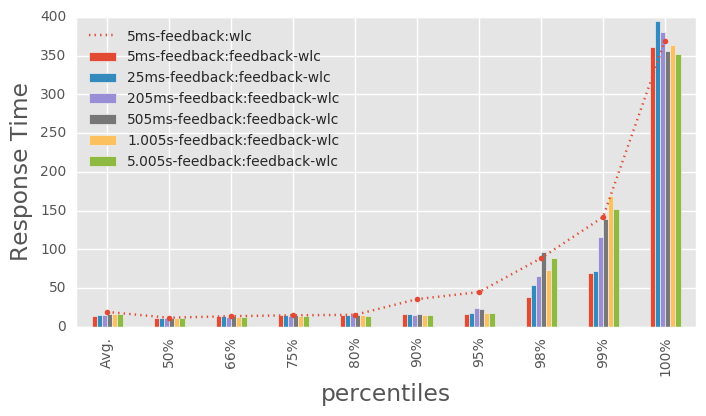

In [26]:
ax = means[["5ms-feedback:wlc"]].plot(kind='line', yerr=errs, figsize=(8,4), linestyle=":", marker='o', markersize=4)
means[["5ms-feedback:feedback-wlc",
       "25ms-feedback:feedback-wlc",
       "205ms-feedback:feedback-wlc",
       "505ms-feedback:feedback-wlc",
       "1.005s-feedback:feedback-wlc",
       "5.005s-feedback:feedback-wlc"]].plot(kind='bar', yerr=errs, figsize=(8,4), ax=ax)
ax.set_ylabel('Response Time')
fig = ax.get_figure()
fig.savefig('time-scales-plots-with-wlc-trendline.pdf')

In [27]:
means.describe()

,5ms-feedback:wlc,5ms-feedback:feedback-wlc,25ms-feedback:feedback-wlc,205ms-feedback:feedback-wlc,505ms-feedback:feedback-wlc,1.005s-feedback:feedback-wlc,5.005s-feedback:feedback-wlc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,75.538750,57.221250,62.425000,67.053750,70.261250,70.855000,69.375000
std,111.425315,108.491184,118.532025,114.945328,109.405037,114.136799,109.772634
min,11.750000,11.000000,11.500000,10.875000,11.500000,11.000000,10.875000
25%,15.031250,14.596875,14.875000,14.281250,14.687500,14.343750,14.125000
50%,27.506250,15.437500,15.625000,15.768750,16.493750,15.962500,15.812500
75%,77.687500,33.500000,44.468750,55.437500,78.000000,59.531250,70.500000
max,369.375000,361.625000,394.750000,380.000000,355.625000,363.375000,352.625000


### Below ... 

500ms fluctuation, 0.5 alpha, 0.001 state feedback, 0.001 stat collection.

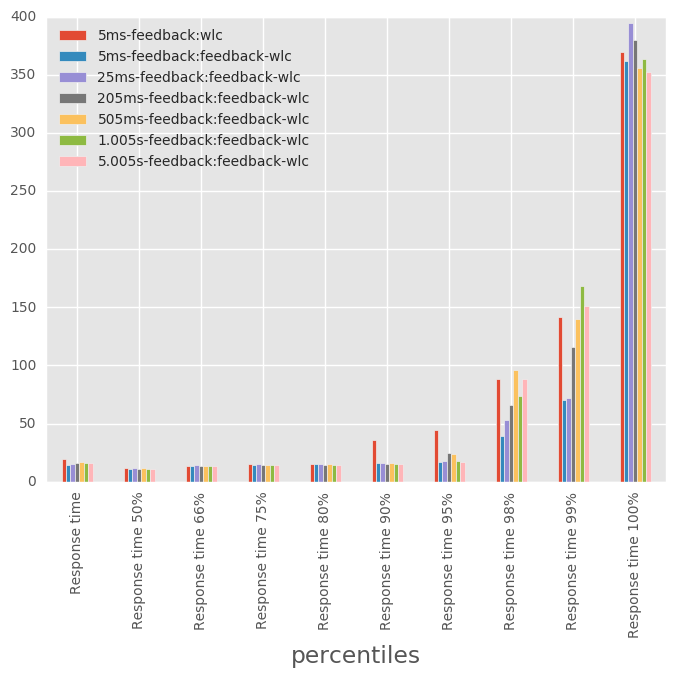

In [29]:
for run in runs:
    param_list = ['percentiles']
    for feedback_interval in feedback_intervals:
        for algo in algos:
            if feedback_interval != '5ms-feedback' and algo == 'wlc':
                continue
            param_list.append(feedback_interval+":"+algo)
    rt_plot_data[param_list].plot('percentiles', kind='bar')

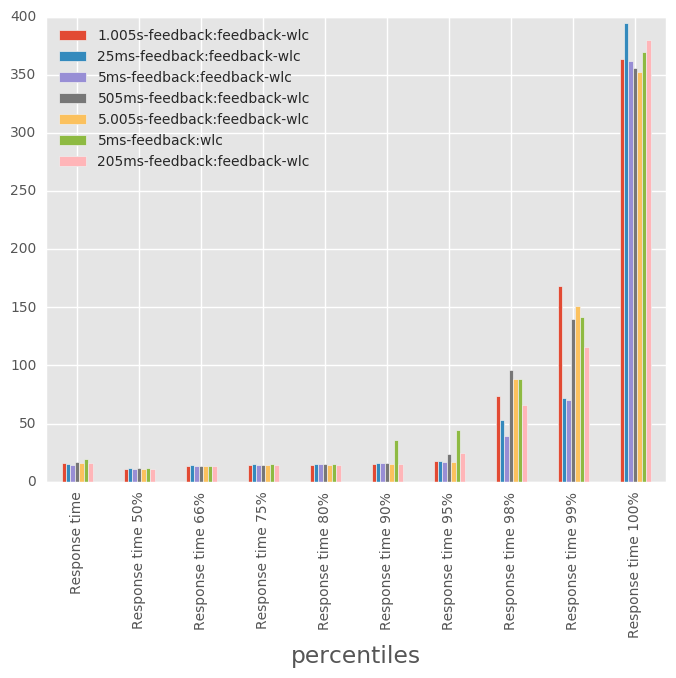

In [30]:
rt_plot_data.plot('percentiles', kind='bar')